# Amazon Beauty Reviews Sentiment Analysis

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from nltk import word_tokenize
from string import punctuation
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import precision_score, confusion_matrix
from textblob import TextBlob
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
import itertools
import seaborn as sns
from scipy.stats import ttest_ind

/Users/aubreybrowne/anaconda/envs/nlp/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Preprocessing

In [2]:
# read the entire file into a python array
with open('Beauty_5.json', 'rb') as f:
    reviews = f.readlines()

data = [line.decode('utf-8') for line in reviews]
# remove the trailing "\n" from each line
data_clean = map(lambda x: x.rstrip(), data)

# each element of 'data' is an individual JSON object.
# i want to convert it into an *array* of JSON objects
# which, in and of itself, is one large JSON object
# basically... add square brackets to the beginning
# and end, and have all the individual business JSON objects
# separated by a comma
data_json_str = "[" + ','.join(data_clean) + "]"

# now, load it into pandas
beauty = pd.read_json((data_json_str))

In [3]:
#cleaning data...lowercase
beauty['reviewText'] = beauty['reviewText'].str.lower()

In [4]:
def remove_punctuations(text):
    for punct in punctuation:
        text = text.replace(punct, ' ')
    return text

In [5]:
# remove punctuation
beauty['reviewText'] = beauty['reviewText'].apply(remove_punctuations)

In [6]:
# remove stopwords
stop = stopwords.words('english')
beauty['reviewText'] = beauty['reviewText'].apply(lambda x: ' '.join([item for item in x.split() if item not in stop]))

In [7]:
# creating a tokenized column for the reviewText
beauty['reviewText_tok'] = beauty['reviewText'].apply(word_tokenize)

In [8]:
# creating a positive negative column where positive review (4-5) are 1 and negative reviews (1-3) are 0.
beauty['pos_neg'] = beauty['overall'].apply(lambda x: 1 if x > 3 else 0)

In [9]:
beauty.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,reviewText_tok,pos_neg
0,7806397051,"[3, 4]",1,oily creamy expected ordered try highlight con...,"01 30, 2014",A1YJEY40YUW4SE,Andrea,Don't waste your money,1391040000,"[oily, creamy, expected, ordered, try, highlig...",0
1,7806397051,"[1, 1]",3,palette decent price looking different shades ...,"04 18, 2014",A60XNB876KYML,Jessica H.,OK Palette!,1397779200,"[palette, decent, price, looking, different, s...",0
2,7806397051,"[0, 1]",4,texture concealer pallet fantastic great cover...,"09 6, 2013",A3G6XNM240RMWA,Karen,great quality,1378425600,"[texture, concealer, pallet, fantastic, great,...",1
3,7806397051,"[2, 2]",2,really tell exactly thing powder kind oil ish ...,"12 8, 2013",A1PQFP6SAJ6D80,Norah,Do not work on my face,1386460800,"[really, tell, exactly, thing, powder, kind, o...",0
4,7806397051,"[0, 0]",3,little smaller expected okay lasted long time ...,"10 19, 2013",A38FVHZTNQ271F,Nova Amor,It's okay.,1382140800,"[little, smaller, expected, okay, lasted, long...",0


## Text Blob Sentiment Grouped by Product

In [10]:
grouped = beauty['reviewText'].groupby(beauty['asin']).sum()
print(len(grouped))
grouped.head()

12101


asin
7806397051    oily creamy expected ordered try highlight con...
9759091062    nothing stings put used whole tube nothing lig...
9788072216    big fan prada fragrances years absolutely fell...
9790790961    picky comes fragrance love wear want leave oth...
9790794231    like perfume first discovered insert magazine ...
Name: reviewText, dtype: object

In [11]:
first = grouped[grouped.index[0]]

In [12]:
# x must be an asin number from the grouped series
def product_sentiment(x):
    reviews = TextBlob(grouped[str(x)])
    return reviews.sentiment.polarity

In [13]:
product_sentiment(9790790961)

0.3720697541452258

In [14]:
sentiments = []
for x in grouped.index:
    sentiments.append(product_sentiment(x))
#sentiments

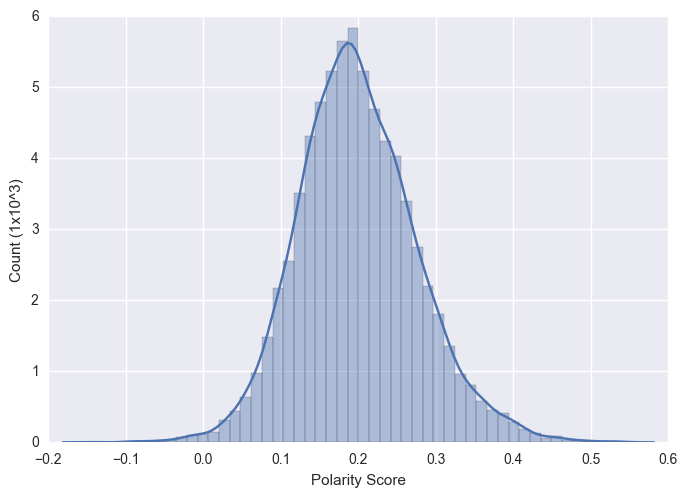

In [15]:
plot = sns.distplot(sentiments);
plot.set(xlabel='Polarity Score', ylabel='Count (1x10^3)')
plt.show()

In [16]:
np.mean(sentiments)

0.19906633880798294

In [17]:
sort_sentiments_neg = sorted(sentiments)
sort_sentiments_neg[:5]

[-0.1460401891252955,
 -0.09779411764705881,
 -0.09265873015873015,
 -0.08664502164502164,
 -0.0831845238095238]

In [18]:
sort_sentiments_pos = sorted(sentiments, reverse=True)
sort_sentiments_pos[:5]

[0.546,
 0.5284313725490195,
 0.5277777777777778,
 0.5261904761904762,
 0.5258730158730158]

In [19]:
def product_num(x):
    return grouped.index[sentiments.index(x)]

### Most Negative

In [20]:
sentiments

[0.19816326530612247,
 -0.015563725490196072,
 0.39287698412698413,
 0.3720697541452258,
 0.20075944170771753,
 0.1094003086227967,
 0.17518701840794867,
 0.2447150072150072,
 0.305407444668008,
 0.19697047000618434,
 0.22061586850649362,
 0.18718956482114377,
 0.13590137426675888,
 0.2243313829028115,
 0.11904925346762081,
 0.22380952380952376,
 0.3276923076923077,
 0.11449323593073595,
 0.2758201058201058,
 0.07090694715295362,
 0.1719668032502257,
 0.1480952380952381,
 0.16379490392648288,
 0.18384413067552602,
 0.1786616161616162,
 0.2727002164502164,
 0.1308755760368664,
 0.17237890061327557,
 0.1946540817283851,
 0.06317793317793319,
 0.17267316017316015,
 0.16341161121983044,
 0.2230128205128205,
 0.09676434676434677,
 0.12383219954648528,
 0.18654733424470268,
 0.13939445970695968,
 0.170305394443744,
 0.19781605975723623,
 0.12839568941696608,
 0.13924832743014556,
 0.10405913978494626,
 0.11967304625199363,
 0.12507134313055365,
 0.19158874458874461,
 0.19741666666666668,
 0.

In [21]:
product_num(-0.1460401891252955)
#Red Carpet Manicure Structure Base Coat Gel, 0.30 Ounce

'B005JYP854'

In [22]:
product_num(-0.1460401891252955)

'B005JYP854'

In [23]:
product_num(-0.09779411764705881)
# frizz control spray

'B000EODF9K'

In [24]:
product_num(-0.09265873015873015)
# Miracell ProEar-for Itchy, Irritated Ears .5 OZ 

'B0001AGMWE'

In [25]:
product_num(-0.08664502164502164)
#Beaute Galleria - Spring Facial Hair Removal Stick Epilator Threading Beauty Too

'B00CU5749S'

In [26]:
product_num(-0.0831845238095238)
# Relief Epsom Salt Lavender - Calming & Relaxing Soak, 16 oz,(Blue Cross Laboratories)

'B004XY1CY2'

### Most Positive

In [27]:
product_num(0.546)
# I couldn't find it but it was a perfume of some sort

'B000R4DZRE'

In [28]:
product_num(0.5284313725490195)
#It Cosmetics Heavenly Luxe Buffing Airbrush Foundation Brush

'B00AWXC2XS'

In [29]:
grouped[sentiments.index(0.5284313725490195)]

'softttti love brush fall yet hopefully never makes great blush brush blends makeup wellbrush worth price love well makeup applied brush gives airbrushed look buying brushes companypurchased brush looking nice airbrush finish foundation application loved much currently purchasing whole line cosmetics makeup brush line great product made excellently shedding whatsoever greatly recommendhigh quality brush price hesitate try use apply tarte foundation rather giant brush get product one perfect size washes well clarifying shampoo dries quickly propped tumbler brush head stays full firmbest quality brushes ever used soft touch shedding brushes blend makeup perfectly'

In [30]:
product_num(0.5277777777777778)
#Suave Professionals Mens, 3 in 1 Shampoo/Conditioner/Body Wash, Citrus Rush, 28oz 

'B006N9LWWW'

In [31]:
product_num(0.5261904761904762)
# Suave Skin Solutions Lotion Pump, Soothing Aloe, 18 Ounce

'B002DMQRXW'

In [32]:
product_num( 0.5258730158730158)
# ??

'B004VUJX44'

### Interesting Case

In [33]:
sentiments.index(-0.009599929359343574)

234

In [34]:
grouped.index[234]

'B0000YUXI0'

** This example used language such as disgusting, sucks, and bitter which generally would have been a considered negative.  However, the goal of the product was to deter nail biting and thumb sucking so the use of these terms was positive. **



### Positive Reveiws Sentiment Polarity Text Blob

In [41]:
pos_reviews = beauty[beauty.pos_neg == 1]
neg_reviews = beauty[beauty.pos_neg == 0]
#pos_reviews.head()

In [36]:
grouped_pos = pos_reviews['reviewText'].groupby(pos_reviews['asin']).sum()
print(len(grouped_pos))
grouped_pos.head()

12086


asin
7806397051    texture concealer pallet fantastic great cover...
9759091062    bought product 3 months ago finished tube xtre...
9788072216    big fan prada fragrances years absolutely fell...
9790790961    picky comes fragrance love wear want leave oth...
9790794231    unique scent deep mysterious light floral time...
Name: reviewText, dtype: object

In [37]:
sentiments_pos = []
for x in grouped_pos.index:
    sentiments_pos.append(product_sentiment(x))
#sentiments_pos

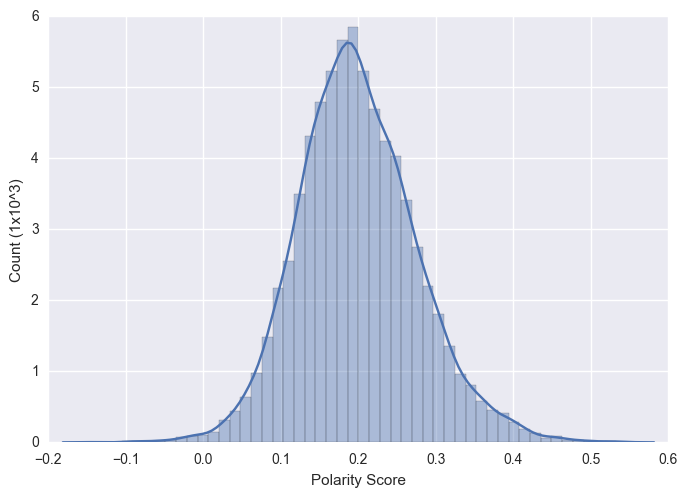

In [38]:
plot = sns.distplot(sentiments_pos);
plot.set(xlabel='Polarity Score', ylabel='Count (1x10^3)')
plt.show()

In [39]:
np.mean(sentiments_pos)

0.19917809857173735

** This is only slightly more positive than the overall reviews (0.19906633880798294). This is understandable since the majority of reviews are in fact positive. **

In [42]:
grouped_neg = neg_reviews['reviewText'].groupby(neg_reviews['asin']).sum()
print(len(grouped_neg))
grouped_neg.head()

10023


asin
7806397051    oily creamy expected ordered try highlight con...
9759091062    nothing stings put used whole tube nothing lig...
9790790961    bright crystals reminds victoria secrets gorge...
9790794231    like perfume first discovered insert magazine ...
B00004TMFE    pretty disappointed shampoo conditioner high h...
Name: reviewText, dtype: object

In [43]:
sentiments_neg = []
for x in grouped_neg.index:
    sentiments_neg.append(product_sentiment(x))
#sentiments_neg

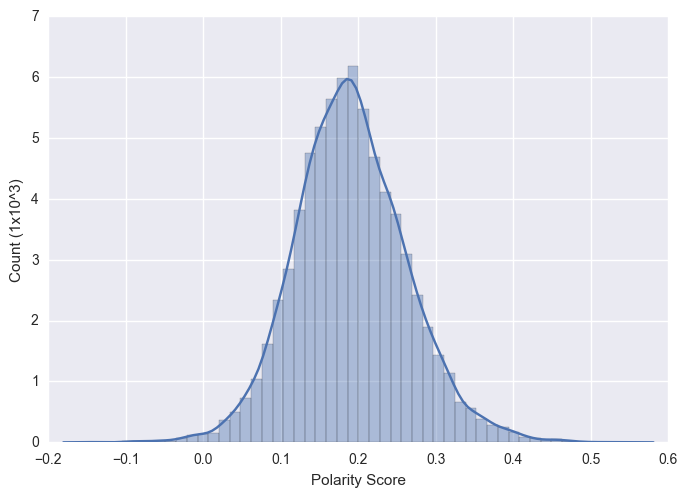

In [44]:
plot = sns.distplot(sentiments_neg);
plot.set(xlabel='Polarity Score', ylabel='Count (1x10^3)')
plt.show()

In [45]:
np.mean(sentiments_neg)

0.19057826841317188

** This is only slightly more negative than the overall reviews (0.19906633880798294). This is understandable since the majority of reviews are in fact positive. Something to note, there is a larger difference between the negative reviews and the overall reviews' polarity then the positive reviews. ** 

[<matplotlib.text.Text at 0x15e0a7630>, <matplotlib.text.Text at 0x15e03c198>]

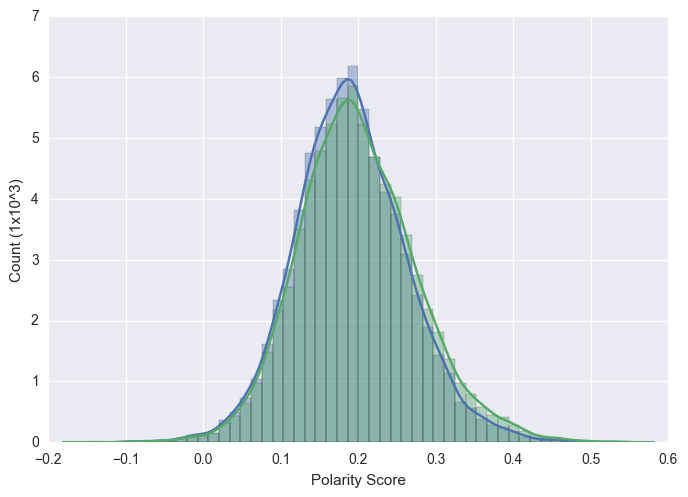

In [46]:
# Blue
plot = sns.distplot(sentiments_neg);
plot.set(xlabel='Polarity Score', ylabel='Count (1x10^3)')
# Green
plot = sns.distplot(sentiments_pos);
plot.set(xlabel='Polarity Score', ylabel='Count (1x10^3)')

** I was surprised about how much overlap there was between the positive and negative reviews. After some research, I found that Amazon will get rid of poor performing products and sellers. Therefore, Amazon wants to minimize the amount of negative reviews since these reviews will effect their overall credability. **

In [47]:
ttest_ind(sentiments_neg, sentiments_pos)

Ttest_indResult(statistic=-8.5371775600761808, pvalue=1.4627534993781884e-17)

** The two curves are actually statistically significantly different according to the ttest since the p-value is less than 0.05 and the t statistic is outside the range of 2, -2. **  

In [63]:
np.mean(sentiments_neg), np.mean(sentiments_pos)

(0.19057826841317188, 0.19917809857173735)

In [56]:
neg_reviews.overall.mean()

2.2650237395432966

**This is interesting since most of the negative reviews seem to be scored at a 3. **

In [57]:
pos_reviews.overall.mean()

4.742396546359676